In [1]:
import tensorflow as tf
import torch
import sys
sys.path.append('../python/')
sys.path.append('../algorithms/')
import bafalo_detector
from utils.dataloader import BarcodeDataset
from torch.utils.data import DataLoader
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU, ReLU, Conv2DTranspose, GlobalMaxPooling2D,Input, Activation, Concatenate, Add, BatchNormalization
from tensorflow.keras.layers import Flatten, Dropout, GaussianNoise, Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.data.experimental import sample_from_datasets
from tensorflow.keras.callbacks import ReduceLROnPlateau
from PIL import Image
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau

import json, cv2, os, random, ctypes, scipy, re
import numpy as np
import time
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from IPython.display import clear_output
import seaborn as sns
from tqdm import tqdm

from arch import BaFaLo_1


%matplotlib inline
pylab.rcParams['figure.figsize'] = (18.0, 9.0)

2024-11-22 16:00:06.322972: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 16:00:06.322999: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 16:00:06.323029: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 16:00:06.329556: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/dl.net/evezzali/.local/lib/python3.10/site-p

In [74]:
images_path = "../dataset/images/"
annotations_path = "../annotations/COCO/"
batch_size = 32
longest_edge_size = 640

train_dataset = BarcodeDataset(f'{annotations_path}train.json', images_path, clahe = False,
                            max_size=longest_edge_size, downscale_factor=1, remove_first_ch = False, gray_scale = True, dist_map=False)
dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = BarcodeDataset(f'{annotations_path}val.json', images_path, clahe=False,
                            max_size=longest_edge_size, downscale_factor=1, remove_first_ch = False, gray_scale = True, dist_map=False)
dataloader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.30s)
creating index...
index created!


In [76]:
import itertools
model = torch.load('../Saved_Models/fscnn_nano_320_0.pt').cuda()
total_area = 0
total_gt_area = 0
total_predicted_area = 0
FN_area = 0
FP_area = 0
th = 0.25
for i, data in tqdm(enumerate(dataloader_train)):
    inputs, labels = data
    inputs = inputs.cuda()
    predicted_labels = torch.nn.Sigmoid()(model(inputs)).cpu().detach().numpy()
    predicted_labels = np.int32(predicted_labels > th)
    gt_labels = labels.numpy()[:,1:]
    total_area += 32*320**2
    total_gt_area += np.sum(gt_labels)
    total_predicted_area += np.sum(predicted_labels)
    FN_area += np.sum(np.clip(gt_labels - predicted_labels,0,1))

2it [00:03,  1.81s/it]


KeyboardInterrupt: 

In [50]:
print(0.6*total_area/1e6, total_gt_area/1e6, total_predicted_area/1e6, FN_area/1e6)

320.47104 24.821004 29.702126 0.203798


In [66]:
import itertools
tiling = True
t_size = 160
model = torch.load('../Saved_Models/fscnn_nano_640_0.pt').cuda()
for i, data in tqdm(enumerate(dataloader_train)):
    inputs, labels, _ = data
    inputs = inputs.cuda()
    predicted_labels = torch.from_numpy(np.ones((batch_size,2,640,640), dtype=np.float32))
    if tiling:
        for j, k in itertools.product(range(640//t_size), range(640//t_size)):
            predicted_labels[:,:,j*t_size:(j+1)*t_size, k*t_size:(k+1)*t_size] = model(inputs[:,:,j*t_size:(j+1)*t_size, k*t_size:(k+1)*t_size])
    else:
        predicted_labels = model(inputs)

5it [00:07,  1.48s/it]


KeyboardInterrupt: 

In [58]:
index = 4
mapp = np.array(labels[index][0]+labels[index][1])
prediction = torch.nn.Sigmoid()(predicted_labels).cpu().detach().numpy()[index]
print(prediction.max(), prediction.min())
prediction = np.clip(prediction[0],0,1)+np.clip(prediction[1],0,1)>0.4
H, W = mapp.shape
img = np.squeeze(np.transpose(inputs[index].cpu().detach().numpy(),(1,2,0)))
#clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(16,16))
#cl1 = clahe.apply(np.uint8(img*255))
#prediction = model(torch.from_numpy(np.float32(cl1[np.newaxis, np.newaxis]/255.0)).cuda())
#prediction = np.squeeze(prediction.cpu().detach().numpy())
#prediction = np.clip(prediction[0],0,1)+np.clip(prediction[1],0,1)>0.01
mapp_downscaled = cv2.resize(mapp, (W//32, H//32), interpolation=cv2.INTER_AREA)

0.7841138 0.00033476748


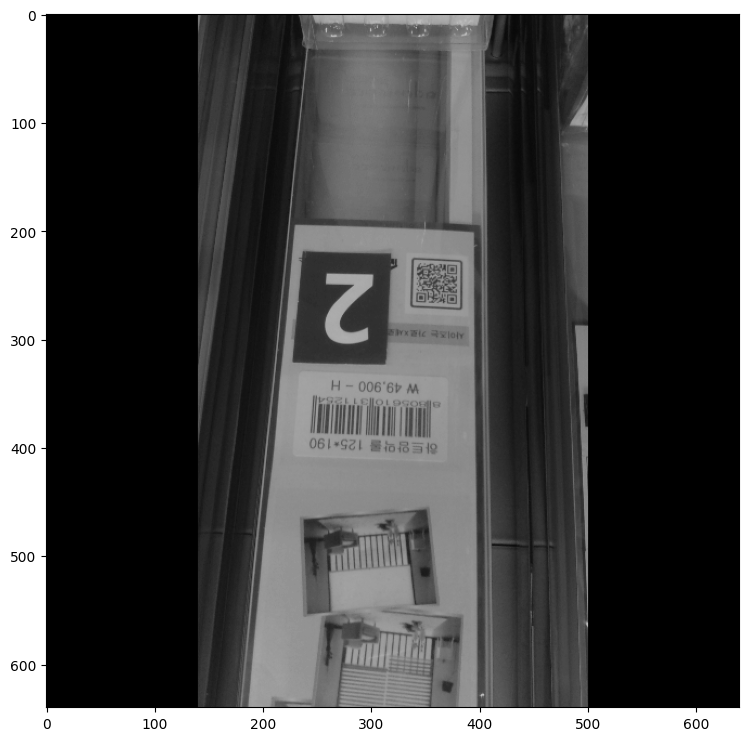

In [59]:
plt.imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)

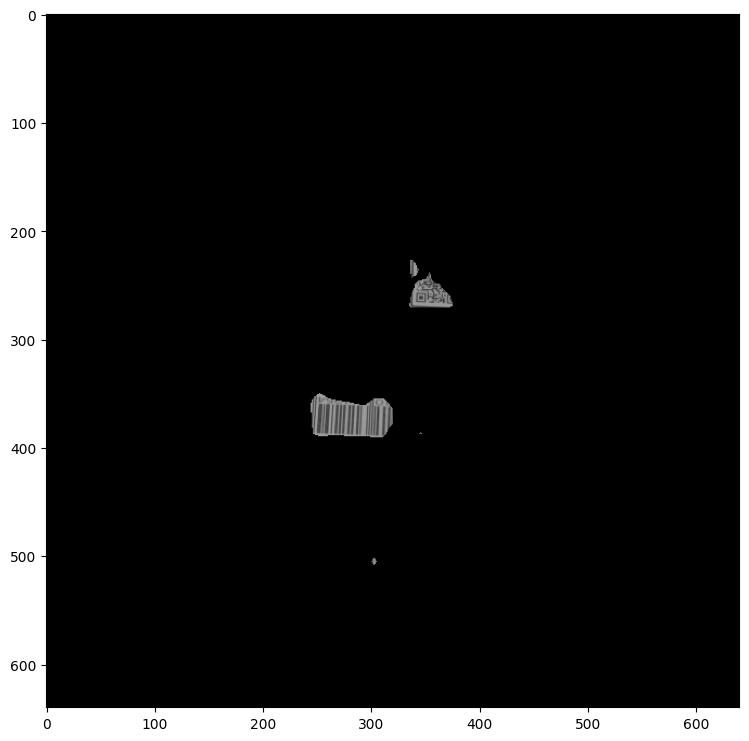

In [60]:
plt.imshow(img*prediction, cmap=plt.cm.gray, vmin=0, vmax=1)

In [45]:
sys.path.append('../python/') 
from utils.utility import get_contours_and_boxes
contours, boxes =  get_contours_and_boxes(np.uint8(prediction), min_area=300)

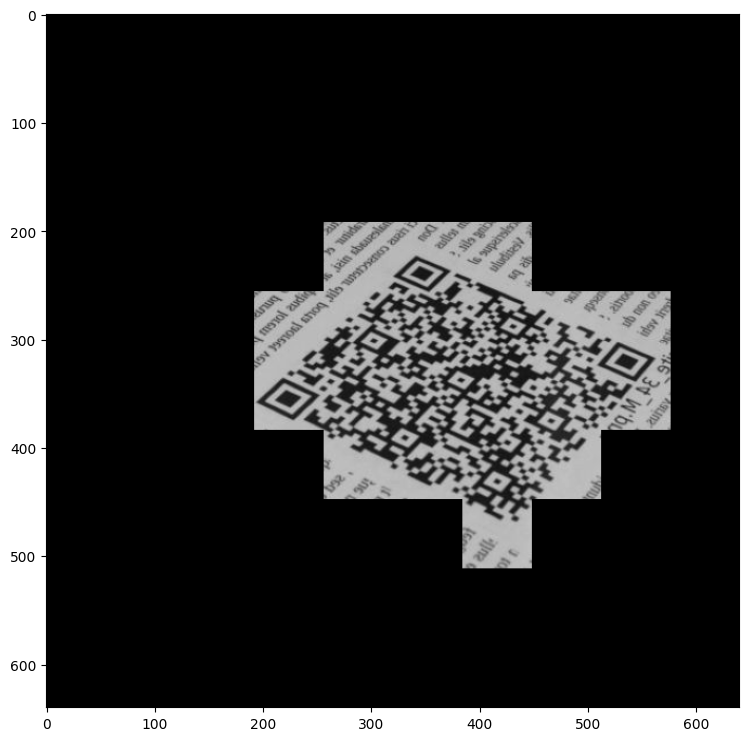

In [46]:
mapp = cv2.resize(prediction.astype('float32'), (10,10), interpolation=cv2.INTER_AREA)
mapp = np.float32(mapp>0.02)
mapp = cv2.resize(mapp, (640,640), interpolation=cv2.INTER_NEAREST)
plt.imshow(mapp*img, cmap=plt.cm.gray, vmin=0, vmax=1)